# Optical Etch Detection Algorithm
This notebook walks through the etch detection pipeline in three stages: preprocessing, circularity filtering, and results summary.

Dependencies: opencv-python, numpy, matplotlib. Install via [requirements.txt](requirements.txt).

## Step 1: Image Loading and Brightness Filter
Load the image, convert to grayscale, and apply brightness filter to passeed etchings

Brightness percentile (CDF): 0.999
Pixel threshold value: 148
Contours detected: 66
Pixels above threshold: 0.10%


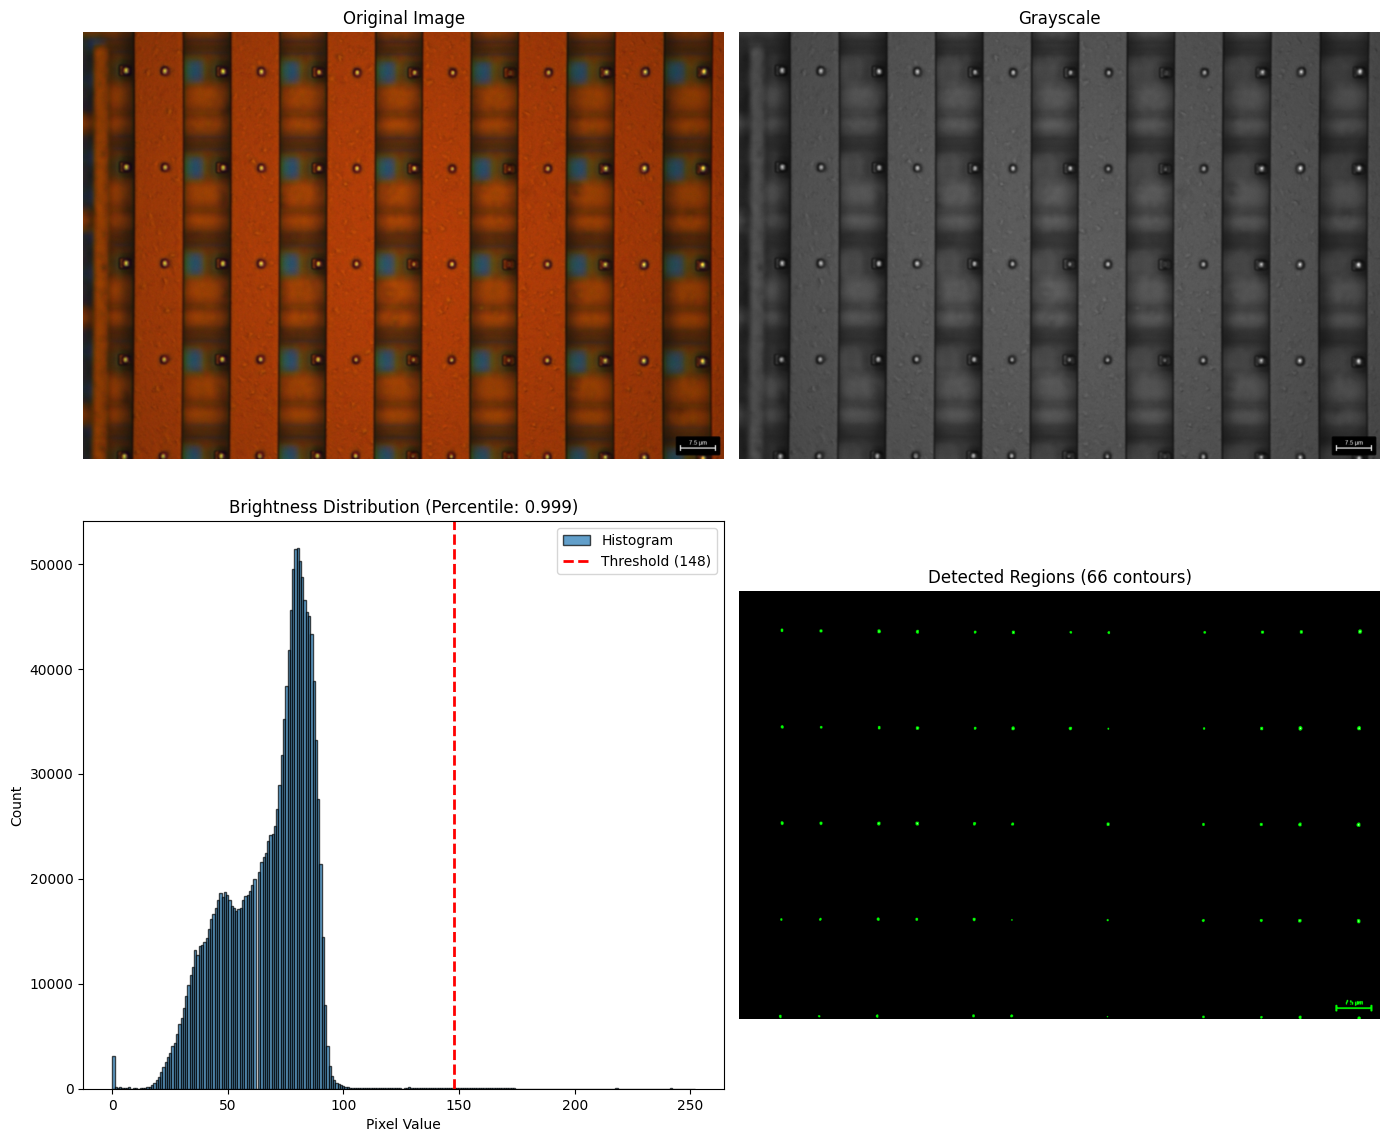

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("Optical_Imaging_1T1R_Arrays_VIA_etch/Array5_Reticle3.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Smart brightness threshold using CDF (0-1 scale for generalization)
brightness_percentile = 0.999  # Select brightest 15% of pixels

# Calculate histogram and CDF
hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
cdf = np.cumsum(hist) / np.sum(hist)

# Find pixel value corresponding to the percentile
threshold_idx = np.searchsorted(cdf, brightness_percentile)
brightness_threshold = int(threshold_idx)

# Apply threshold
binary_brightness = cv2.threshold(gray, brightness_threshold, 255, cv2.THRESH_BINARY)[1]

# Find contours
contours_bright, _ = cv2.findContours(binary_brightness, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Brightness percentile (CDF): {brightness_percentile}")
print(f"Pixel threshold value: {brightness_threshold}")
print(f"Contours detected: {len(contours_bright)}")
print(f"Pixels above threshold: {np.sum(binary_brightness > 0) / gray.size * 100:.2f}%")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top left: Original image
axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Top right: Grayscale
axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Grayscale')
axes[0, 1].axis('off')

# Bottom left: Histogram with CDF threshold
axes[1, 0].hist(gray.flatten(), bins=256, edgecolor='black', alpha=0.7, label='Histogram')
axes[1, 0].axvline(x=brightness_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({brightness_threshold})')
axes[1, 0].set_title(f'Brightness Distribution (Percentile: {brightness_percentile})')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Bottom right: Binary with contours
img_contours_bright = cv2.cvtColor(binary_brightness, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours_bright, contours_bright, -1, (0, 255, 0), 2)
axes[1, 1].imshow(cv2.cvtColor(img_contours_bright, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'Detected Regions ({len(contours_bright)} contours)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 2: Filter Circular Etchings
Identify circular dots by calculating circularity for each contour.
Etchings are circular, so we filter by circularity threshold (0.0 to 1.0, where 1.0 = perfect circle).

Step 2 - Circularity filtering:
  Circularity threshold: 0.65
  Circular etchings found: 53
  Circularity range: 0.000 to 0.943
  Area range: 1.0 to 35.0 pixels²
  Area mode (most common): 18.6 pixels²
  Area mean: 15.5 pixels²


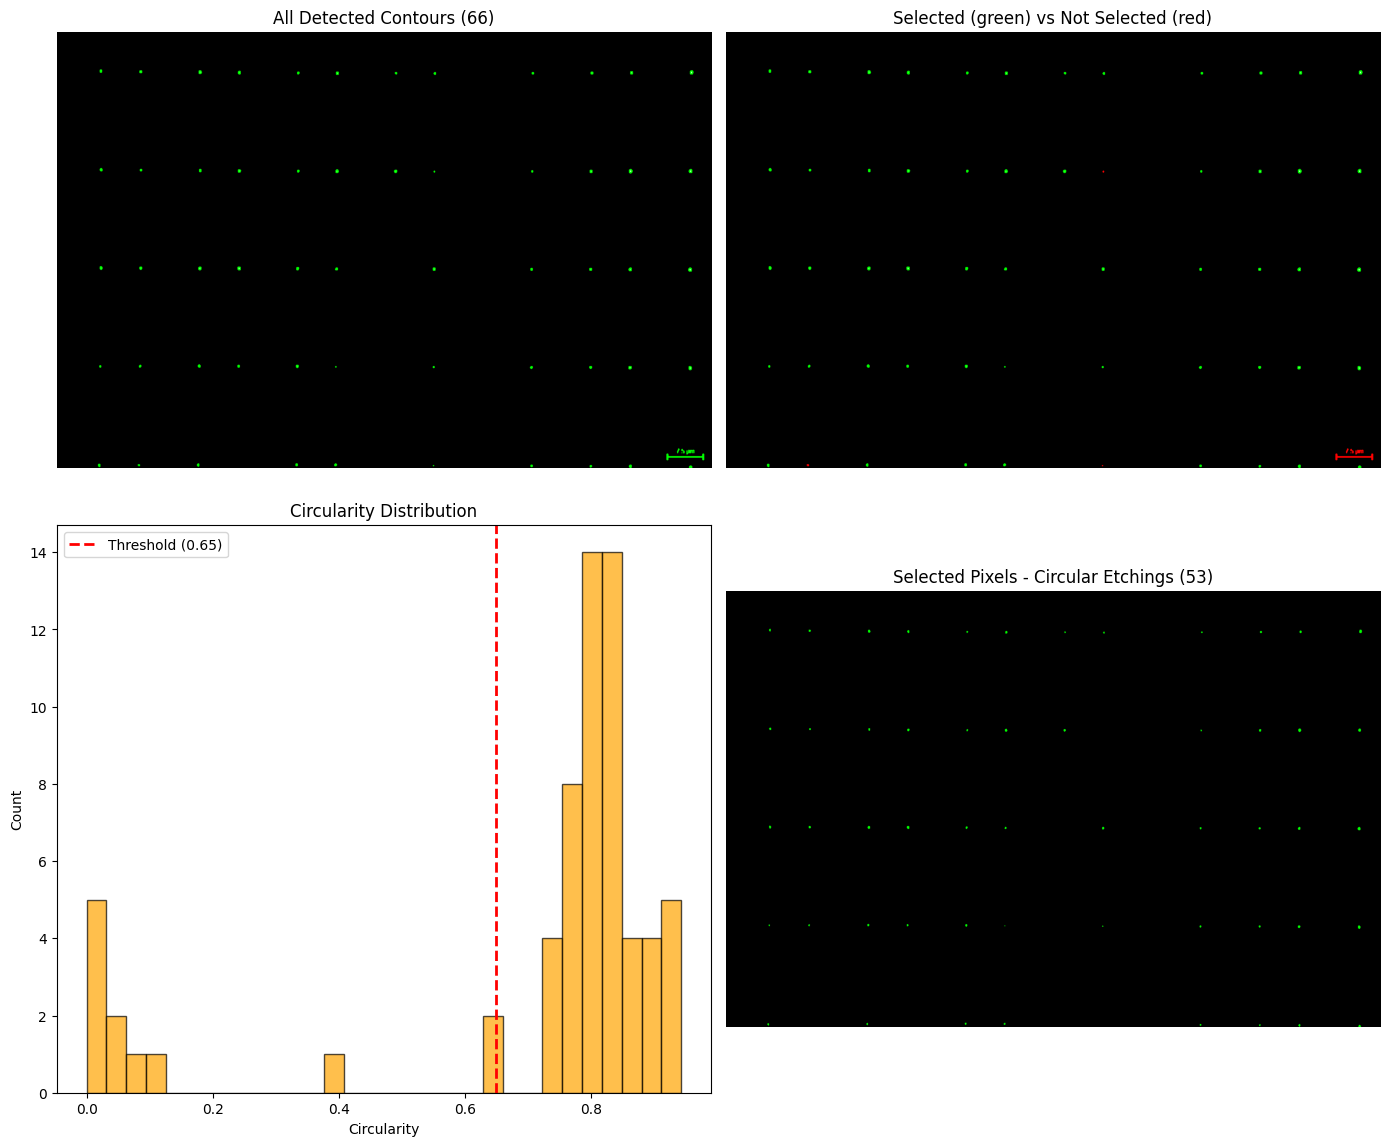

In [9]:
# Step 2: Filter contours by circularity
circularity_threshold = 0.65  # Keep only reasonably circular dots

circular_etchings = []
circularity_values = []

for cnt in contours_bright:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    if perimeter == 0:
        continue
    
    # Calculate circularity
    circularity = 4 * np.pi * area / (perimeter ** 2)
    circularity_values.append(circularity)
    
    if circularity > circularity_threshold:
        circular_etchings.append({
            'contour': cnt,
            'circularity': circularity,
            'area': area
        })

print(f"Step 2 - Circularity filtering:")
print(f"  Circularity threshold: {circularity_threshold}")
print(f"  Circular etchings found: {len(circular_etchings)}")
print(f"  Circularity range: {min(circularity_values):.3f} to {max(circularity_values):.3f}")

# Calculate area statistics
areas = [etch['area'] for etch in circular_etchings]
if areas:
    counts, bins = np.histogram(areas, bins=30)
    mode_idx = np.argmax(counts)
    mode_area = (bins[mode_idx] + bins[mode_idx + 1]) / 2  # Bin center
    print(f"  Area range: {min(areas):.1f} to {max(areas):.1f} pixels²")
    print(f"  Area mode (most common): {mode_area:.1f} pixels²")
    print(f"  Area mean: {np.mean(areas):.1f} pixels²")

# Visualize Step 2
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Top left: Original contours (all)
img_all_contours = cv2.cvtColor(binary_brightness, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_all_contours, contours_bright, -1, (0, 255, 0), 2)
axes[0, 0].imshow(cv2.cvtColor(img_all_contours, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f'All Detected Contours ({len(contours_bright)})')
axes[0, 0].axis('off')

# Top right: Selected (green) vs not selected (red)
img_selection = cv2.cvtColor(binary_brightness, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_selection, contours_bright, -1, (0, 0, 255), 2)
for etch in circular_etchings:
    cv2.drawContours(img_selection, [etch['contour']], -1, (0, 255, 0), 2)
axes[0, 1].imshow(cv2.cvtColor(img_selection, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f'Selected (green) vs Not Selected (red)')
axes[0, 1].axis('off')

# Bottom left: Circularity distribution histogram
axes[1, 0].hist(circularity_values, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].axvline(x=circularity_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({circularity_threshold})')
axes[1, 0].set_title('Circularity Distribution')
axes[1, 0].set_xlabel('Circularity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Bottom right: Binary mask of selected circular etchings
img_selected = np.zeros((binary_brightness.shape[0], binary_brightness.shape[1], 3), dtype=np.uint8)
for etch in circular_etchings:
    cv2.drawContours(img_selected, [etch['contour']], -1, (0, 255, 0), -1)
axes[1, 1].imshow(cv2.cvtColor(img_selected, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'Selected Pixels - Circular Etchings ({len(circular_etchings)})')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Summary: Complete Etch Detection Process
This visualization shows the complete pipeline from raw image to final detection results.

**Process Overview:**
1. **Original Image** → Input optical microscopy image
2. **Grayscale Image** → Convert to single channel for analysis
3. **Brightness Filter** → Keep only the brightest 0.1% of pixels (etchings are bright)
4. **Roundness Filter** → Keep only circular objects (etchings are round, remove noise)
5. **Test Results** → Final detected etchings marked on original image

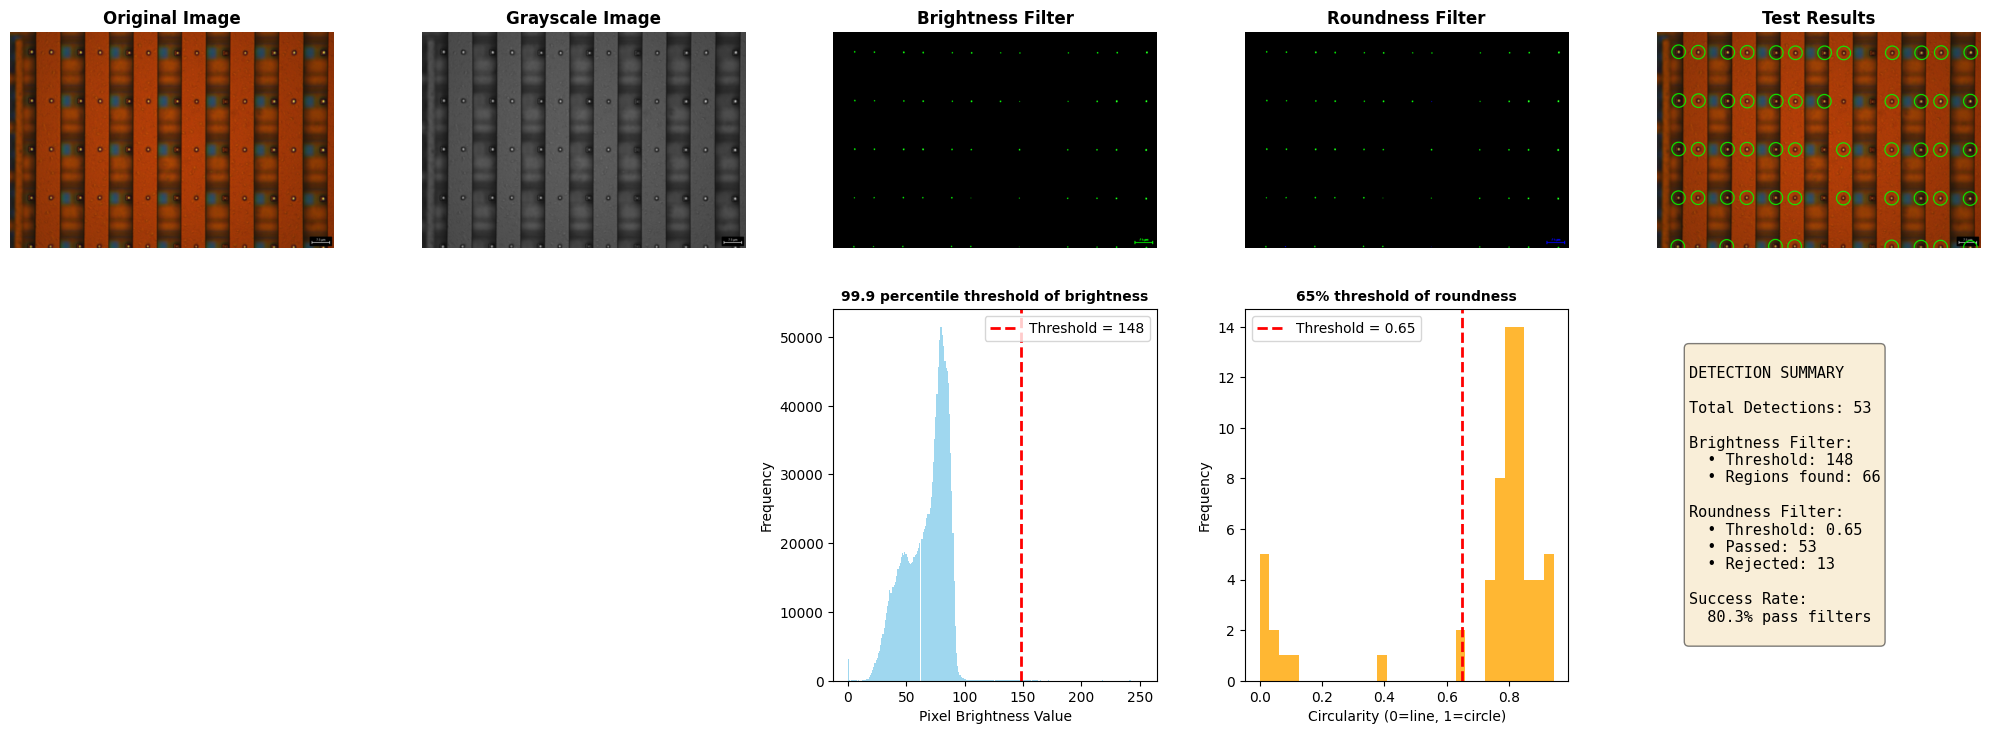


✓ Pipeline complete: 53 etchings detected!


In [10]:
# Complete Pipeline Visualization
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# ROW 1, COL 1: Original Image
axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# ROW 1, COL 2: Grayscale Image
axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Grayscale Image', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# ROW 1, COL 3: Brightness Filter (Step 1 output)
img_brightness_filter = cv2.cvtColor(binary_brightness, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_brightness_filter, contours_bright, -1, (0, 255, 0), 2)
axes[0, 2].imshow(cv2.cvtColor(img_brightness_filter, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title('Brightness Filter', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# ROW 1, COL 4: Roundness Filter (Step 2 - green=pass, red=fail)
img_roundness_filter = cv2.cvtColor(binary_brightness, cv2.COLOR_GRAY2BGR)
# Draw all contours in red first
cv2.drawContours(img_roundness_filter, contours_bright, -1, (255, 0, 0), 2)
# Draw circular etchings in green on top
for etch in circular_etchings:
    cv2.drawContours(img_roundness_filter, [etch['contour']], -1, (0, 255, 0), 2)
axes[0, 3].imshow(cv2.cvtColor(img_roundness_filter, cv2.COLOR_BGR2RGB))
axes[0, 3].set_title('Roundness Filter', fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

# ROW 1, COL 5: Test Results (original image with circles at centroids)
img_results = img.copy()
for etch in circular_etchings:
    # Calculate centroid
    M = cv2.moments(etch['contour'])
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        # Draw small green circle at centroid
        cv2.circle(img_results, (cx, cy), 32, (0, 255, 0), 4)
axes[0, 4].imshow(cv2.cvtColor(img_results, cv2.COLOR_BGR2RGB))
axes[0, 4].set_title('Test Results', fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# ROW 2, COL 1-2: Empty (alignment)
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# ROW 2, COL 3: Histogram with brightness threshold (below Brightness Filter)
axes[1, 2].hist(gray.flatten(), bins=256, alpha=0.8, color='skyblue')
axes[1, 2].axvline(x=brightness_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold = {brightness_threshold}')
axes[1, 2].set_title('99.9 percentile threshold of brightness', fontsize=10, fontweight='bold')
axes[1, 2].set_xlabel('Pixel Brightness Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

# ROW 2, COL 4: Circularity distribution (below Roundness Filter)
axes[1, 3].hist(circularity_values, bins=30, alpha=0.8, color='orange')
axes[1, 3].axvline(x=circularity_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold = {circularity_threshold}')
axes[1, 3].set_title('65% threshold of roundness', fontsize=10, fontweight='bold')
axes[1, 3].set_xlabel('Circularity (0=line, 1=circle)')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].legend()

# ROW 2, COL 5: Summary statistics
axes[1, 4].axis('off')
summary_text = f"""
DETECTION SUMMARY

Total Detections: {len(circular_etchings)}

Brightness Filter:
  • Threshold: {brightness_threshold}
  • Regions found: {len(contours_bright)}

Roundness Filter:
  • Threshold: {circularity_threshold}
  • Passed: {len(circular_etchings)}
  • Rejected: {len(contours_bright) - len(circular_etchings)}

Success Rate:
  {len(circular_etchings)/len(contours_bright)*100:.1f}% pass filters
"""
axes[1, 4].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Pipeline complete: {len(circular_etchings)} etchings detected!")